# Tuning Degree Correlations
Step 1: Link Selection
Choose at random two links. Label the four nodes at the end of these two links with a, b, c, and d such that their degrees are ordered as ka≥kb≥kc≥kd <br>
Step 2: Rewiring
Break the selected links and rewire them to form new pairs. Depending on the desired degree correlations the rewiring is done in two ways:<br>
Step 2A: Assortative
By pairing the two highest degree nodes (a with b) and the two lowest degree nodes (c/ with d), we connect nodes with comparable degrees, enhancing the network’s assortative nature.<br>
Step 2B: Disassortative
By pairing the highest and the lowest degree nodes (a with d and b with c), we connect nodes with different degrees, enhancing the network’s disassortative nature.

###### The main ideia is that rewiring the edges we keep the same degree distribution, but inscrease or decrease de assortativity

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statistics as st
import numpy as np
import random as rd

# Functions

In [2]:
#Avarage Neighbors Degree
def averageNeighborsDegree(G,node):
    neighbors=list(nx.neighbors(G,node))
    if(len(neighbors)==0):
        return 0 
    else:
        return sum([nx.degree(G,n) for n in neighbors])/len(neighbors)

def averageNeighborsDegreeByDegree(G,ylim=(0,0),xlim=(0,0)):
    #Get only the Largest Connect Component
    #G = nx.subgraph(G,max(nx.connected_components(G),key=len))
    nodeWithDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in nodeWithDegreeK:
            nodeWithDegreeK[k]=[node]
        else:
            nodeWithDegreeK[k].append(node)
    #Get the average neighbors degree for every node with degree'k'
    for k in nodeWithDegreeK:
        means=0
        for node in nodeWithDegreeK[k]:
            means+=averageNeighborsDegree(G,node)
        nodeWithDegreeK[k]=round(means/len(nodeWithDegreeK[k]),2)

    #Plot the distribution
    plt.figure(figsize=(6,6))
    plt.loglog(list(nodeWithDegreeK.keys()),list(nodeWithDegreeK.values()),'o',color='rebeccapurple')
    #check the scale (custom ou default)
    if ylim==(0,0) or xlim==(0,0):
        ylim=plt.gca().get_ylim()
        xlim=plt.gca().get_xlim()

    #Plot the line for a random prediction
    degree = list(dict(G.degree).values())
    neutralNetwork=round((st.variance(degree) + st.mean(degree)**2)/st.mean(degree),2)
    randomPrediction=[neutralNetwork for x in range(int(xlim[1])+2)]    
    
    plt.loglog(range(int(xlim[1])+2),randomPrediction,'-',color='black')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('K',fontsize=16)
    plt.ylabel(r'$K_n$'r'$_n$(K)',rotation = 0,fontsize=16)
    plt.title(G.name+'\n'+'Assortativity Coefficient: '+str(round(nx.assortativity.degree_assortativity_coefficient(G),2)))
    plt.show()
    
def numberOfDegrees(G):
    numberOfDegreeK={}
    #Get the nodes with degree 'k'
    for node,k in dict(G.degree).items():
        if k not in numberOfDegreeK:
            numberOfDegreeK[k]=1
        else:
            numberOfDegreeK[k]+=1
    
    ordem = sorted(numberOfDegreeK.items())
    ordem = sorted(ordem, key=lambda x:x[1],reverse=True)
    plt.plot(sorted(dict(G.degree).values()),'.')
    plt.title('Distribuição de grau')
    plt.show()


In [3]:
def rewireEdgesForAssortativity(G,increase=True,loops=10):
    for l in range(loops):
        degrees=dict(G.degree())
        edges = list(G.edges())
        rd.shuffle(edges)
        fourNodes={}
        twoEdges = []
        for ed in edges:
            twoEdges.append(ed)            
            if len(twoEdges)==2:
                n1,n2 = twoEdges[0]
                n3,n4 = twoEdges[1]
                #remove the original edges
                G.remove_edge(n1,n2)
                G.remove_edge(n3,n4)
                #get the degree of the four nodes
                fourNodes[n1] = degrees[n1]
                fourNodes[n2] = degrees[n2]
                fourNodes[n3] = degrees[n3]
                fourNodes[n4] = degrees[n4]
                #sort the nodes by degree
                desc = sorted(fourNodes.items(),key=lambda x:x[1],reverse=True) 
                #Keep only the nodes name/label
                desc = [t[0] for t in desc]

                #Sometimes, the same node may be in the two edges, so the len(desc)==3
                if(increase==True):
                    G.add_edge(desc[0],desc[1])
                    if(len(desc)==4):
                        G.add_edge(desc[2],desc[3])
                    else:
                        G.add_edge(desc[1],desc[2])
                else:
                    G.add_edge(desc[1],desc[2])
                    if(len(desc)==4):
                        G.add_edge(desc[0],desc[3])
                    else:
                        G.add_edge(desc[0],desc[2])

                fourNodes={}
                twoEdges = []    
    return G

# Random Network

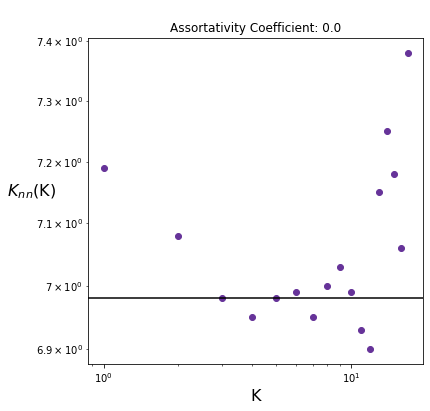

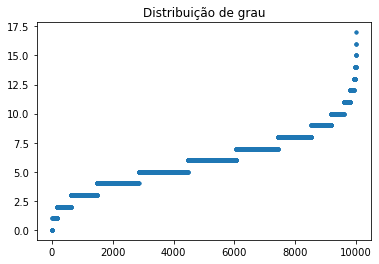

In [4]:
G_random = nx.erdos_renyi_graph(10000,0.0006)
averageNeighborsDegreeByDegree(G_random)
numberOfDegrees(G_random)

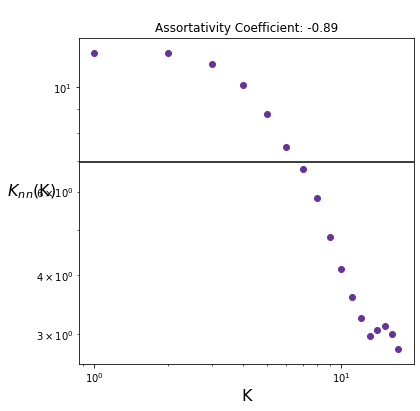

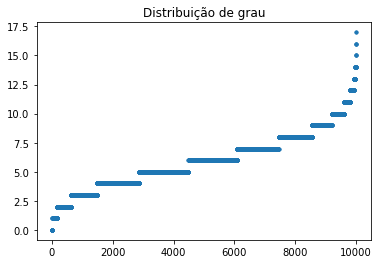

In [5]:
G = rewireEdgesForAssortativity(G_random,increase=False,loops=10)
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)

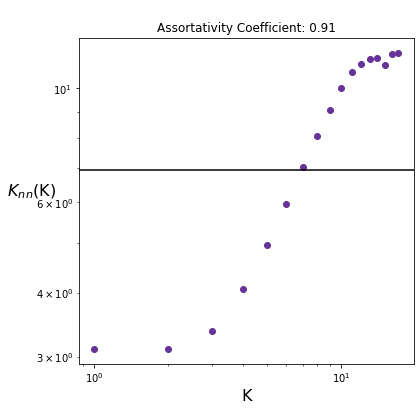

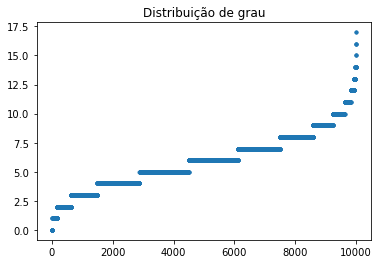

In [6]:
G = rewireEdgesForAssortativity(G_random,increase=True,loops=10)
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)

# Scale-Free

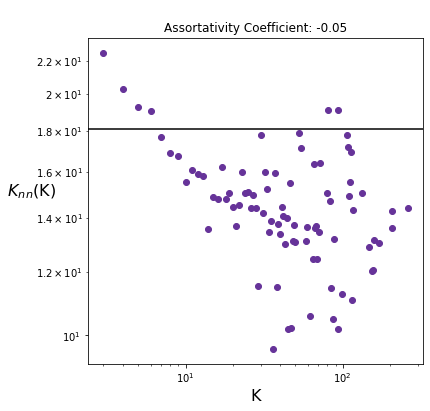

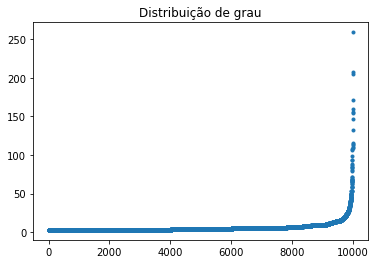

In [7]:
G_scaleFree = nx.barabasi_albert_graph(10000,3)
averageNeighborsDegreeByDegree(G_scaleFree)
numberOfDegrees(G_scaleFree)

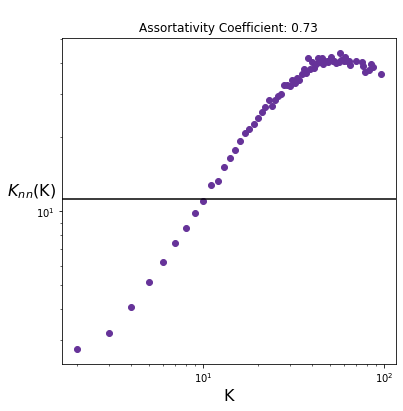

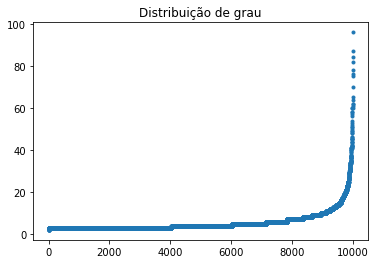

In [8]:
G = rewireEdgesForAssortativity(G_scaleFree,increase=True,loops=10)
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)

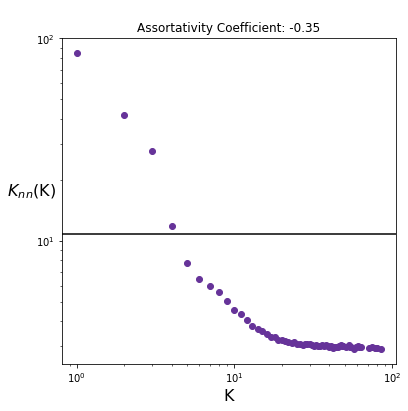

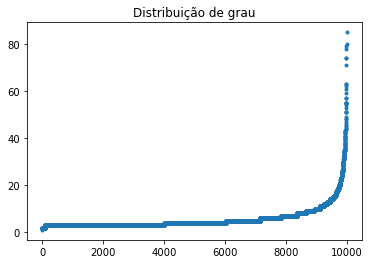

In [9]:
G = rewireEdgesForAssortativity(G_scaleFree,increase=False,loops=10)
averageNeighborsDegreeByDegree(G)
numberOfDegrees(G)